In [44]:
import json
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import Polygon, to_geojson
import pylab as plt
from ortools.sat.python import cp_model

In [45]:
# Load containers in FIWARE data platform
fiware_containers = []
with open("./data/WasteContainers_FIWARE.json") as f:
    fiware_containers = json.load(f)

# Load containers out of FIWARE data platform
df_no_fiware_containers = pd.read_csv("./data/contenedores_aceite_sin_fiware.csv")

# Valencia districts
districts = gpd.read_file("./data/districtes-distritos.geojson")

In [46]:
locations = []

# Clean containers in FIWARE platform
for container in fiware_containers:
    # Filter oil containers
    if "aceiteContenedoresDipu2023" in container["id"]:

        # Check location
        if (container["location"] is not None) and (
            container["location"]["value"] is not None
        ):

            location = {"covered_cells": []}
            location["location"] = [container["location"]["value"]["coordinates"]]
            location["id"] = container["id"]

            locations.append(location)

# Containers out of FIWARE platform
for index, row in df_no_fiware_containers.iterrows():
    location = {"covered_cells": []}
    location["location"] = [[row["geo_point_2d.lon"], row["geo_point_2d.lat"]]]
    location["id"] = row["objectid"]
    locations.append(location)

In [47]:
# Calc isochrones
isochrone_range = [5 * 60]

headers = {
    "Accept": "application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8",
    "Authorization": "5b3ce3597851110001cf62487c1cebfad2324c61823ac5e4fe9be9b1",  # Private
    "Content-Type": "application/json; charset=utf-8",
}

for location in locations:
    body = {"locations": location["location"], "range": isochrone_range}
    call = requests.post(
        " http://localhost:8080/ors/v2/isochrones/foot-walking",
        json=body,
        headers=headers,
    )
    result = call.json()
    location["isochrone"] = Polygon(result["features"][0]["geometry"]["coordinates"][0])

In [48]:
# Create grid
# Source: https://dmnfarrell.github.io/plotting/geopandas-grids
def create_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:29902"):
    """Create square grid that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    see https://james-brennan.github.io/posts/fast_gridding_geopandas/
    """

    import geopandas as gpd
    import shapely

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    # get cell size
    cell_size = (xmax - xmin) / n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            # print (gdf.overlay(poly, how='intersection'))
            grid_cells.append(poly)

    cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        cells = cells.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return cells


# Transform to proxy crs
districts = districts.to_crs("EPSG:29902")

# Create grid
grid = create_grid(districts, n_cells=50, overlap=True, crs="EPSG:29902")

# Transform to original crs
grid = grid.to_crs("EPSG:4326")

# Add incremental ID to cells
grid.insert(0, "id", range(0, len(grid)))

# Transform grid to dict to easilt iterate over cells
grid = grid.to_dict("records")

In [49]:
import json
import rasterio
from rasterio.mask import mask

spanishPopRaster = rasterio.open("./data/spain_pop.tif")


def get_population(poly):
    # Convert string to JSON
    geoJSON = json.loads(poly)

    # Load population raster, mask it by the polygon and crop it
    try:
        out_image, out_transform = mask(spanishPopRaster, [geoJSON], crop=True)

        # Clean negative values
        out_image = out_image[out_image >= 0]

        # Get total population
        totalPop = int(out_image.sum())

        return totalPop
    except ValueError as error:
        return {"error": error}


for cell in grid:
    # Convert shapely.Polygon to geojson
    polygon = to_geojson(cell["geometry"])

    # Get pop in the cell
    population = get_population(polygon)

    # Store it
    cell["population"] = population

<Axes: >

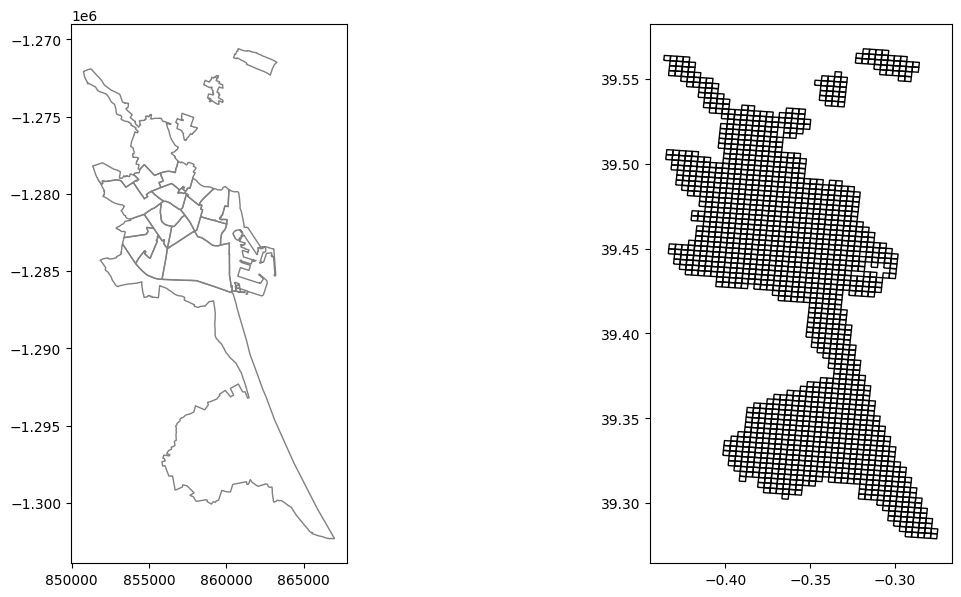

In [50]:
# Convert grid to gdf to easly plot figures
gdf_grid = gpd.GeoDataFrame(grid)

# Plot grid
fig,ax = plt.subplots(1,2,figsize=(14,7))
axs=ax.flat
districts.plot(ec='gray',fc="none",figsize=(10,10),ax=axs[0])
gdf_grid.plot(fc="none", ec='black',ax=axs[1])

In [51]:
# Determine which centroids are covered by the isochrone

# Set default values
for cell in grid:
    cell["currently_covered"] = False
    cell["currently_covered_color"] = "white" # just for plotting purposes

# Which cells are covered
for cell in grid:
    for location in locations:
        if location["isochrone"].contains(cell["geometry"].centroid):
            cell["currently_covered"] = True
            cell["currently_covered_color"] = "green" # just for plotting purposes
            location["covered_cells"].append(cell["id"])



Containers count:  394
Current coverage:


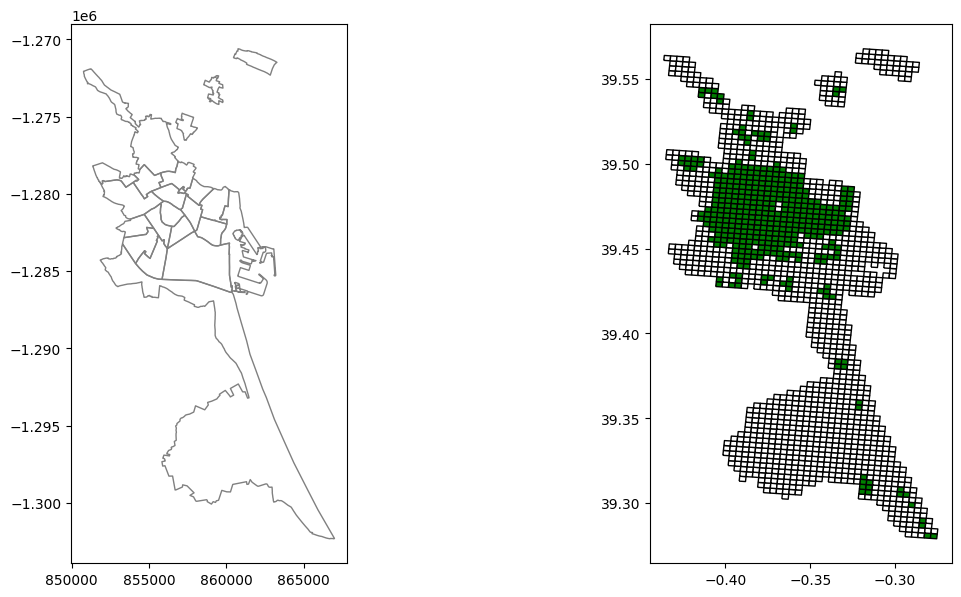

In [52]:
# Convert grid to gdf to easly plot figures
gdf_grid = gpd.GeoDataFrame(grid)

# Plot grid with currently covered cells
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
axs = ax.flat
districts.plot(ec='gray',fc="none",figsize=(10,10),ax=axs[0])
gdf_grid.plot(color=gdf_grid.currently_covered_color, ec="black", ax=axs[1])

print("Containers count: ",len(locations))
print("Current coverage:")
# plt.savefig("./figures/current_coverage.png")

In [53]:
# Optimization model
model = cp_model.CpModel()

# Decision variables
variables = {"Xi": [], "Yj": []}

# Xi: 1 if a container is placed at location i, 0 otherwise
for location in locations:
    v = model.new_bool_var(str(location["id"]))
    variables["Xi"].append(v)

# Yj: 1 if cell j is covered, 0 otherwise
for cell in grid:
    v = model.new_bool_var(str(cell["id"]))
    variables["Yj"].append(v)

# Objective function
model.maximize(
    sum(
        variables["Yj"][j] * grid[j]["population"]
        for j in range(len(variables["Yj"]))
    )
)


# Constraints
def alpha_i_j(location, cell):
    if cell["id"] in location["covered_cells"]:
        alpha_i_j = 1
    else:
        alpha_i_j = 0

    return alpha_i_j


# 1b
for j in range(len(variables["Yj"])):
    model.Add(
        variables["Yj"][j]
        <= sum(
            variables["Xi"][i] * alpha_i_j(locations[i], grid[j])
            for i in range(len(variables["Xi"]))
        )
    )

# 1c
r = 200
model.Add(sum(variables["Xi"]) <= r)


# Solve
solver = cp_model.CpSolver()
status = solver.solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print(f"Optimal solution: {solver.objective_value}\n")

    print("------ Xi ------")
    for i in range(len(variables["Xi"])):
        print(variables["Xi"][i].name, solver.value(variables["Xi"][i]))

    print("------ Yj ------")
    for j in range(len(variables["Yj"])):
        print(variables["Yj"][j].name, solver.value(variables["Yj"][j]))

else:
    print("No solution found.")

Optimal solution: 486023.0

------ Xi ------
aceiteContenedoresDipu2023NB861518040652660 0
aceiteContenedoresDipu2023NB861518040954975 1
aceiteContenedoresDipu2023NB861518040946781 0
aceiteContenedoresDipu2023NB861518040680802 1
aceiteContenedoresDipu2023NB861518040911264 0
aceiteContenedoresDipu2023NB861518040402702 0
aceiteContenedoresDipu2023NB861518040904764 1
aceiteContenedoresDipu2023NB861518040342726 1
aceiteContenedoresDipu2023NB861518040332172 1
aceiteContenedoresDipu2023NB861518040939919 1
aceiteContenedoresDipu2023NB861518040354218 1
aceiteContenedoresDipu2023NB861518040397357 1
aceiteContenedoresDipu2023NB861518040952326 1
aceiteContenedoresDipu2023NB861518040941030 0
aceiteContenedoresDipu2023NB861518040342544 1
aceiteContenedoresDipu2023NB861518040370818 1
aceiteContenedoresDipu2023NB861518040342874 0
aceiteContenedoresDipu2023NB861518040958513 0
aceiteContenedoresDipu2023NB861518040397746 1
aceiteContenedoresDipu2023NB861518040935222 1
aceiteContenedoresDipu2023NB8615180

In [54]:
y_j_solutions = []
for j in range(len(variables["Yj"])):
    y_j_solutions.append(solver.value(variables["Yj"][j]))

In [55]:
x_i_solutions = []
for i in range(len(variables["Xi"])):
    x_i_solutions.append(solver.value(variables["Xi"][i]))


Containers count:  149
Coverage:


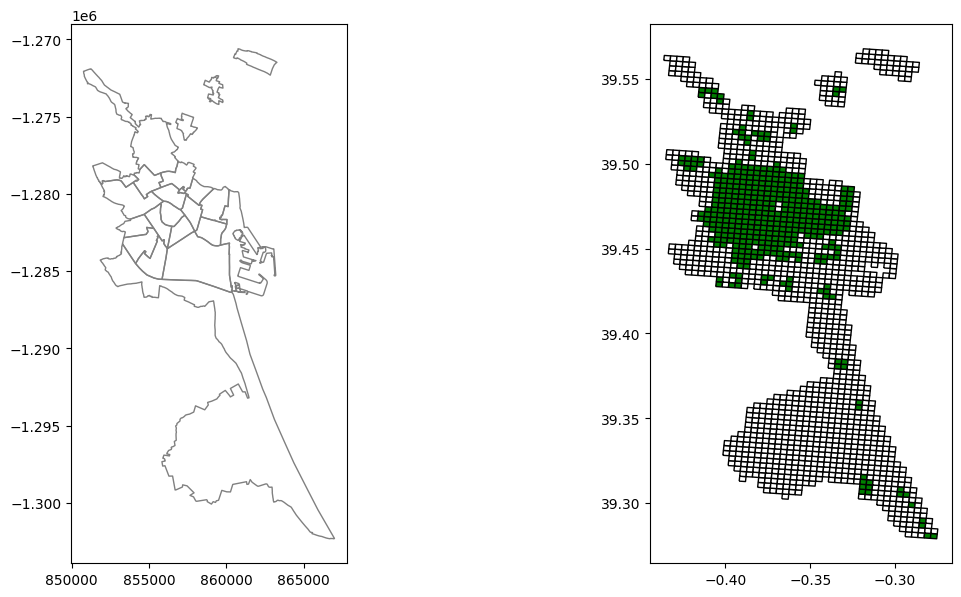

In [56]:
for i in range(len(grid)):
    if y_j_solutions[i] == 1:
        grid[i]["covered"] = True
        grid[i]["color"] = "green"
    else:
        grid[i]["covered"] = False
        grid[i]["color"] = "white"

# Convert grid to gdf to easly plot figures
gdf_grid = gpd.GeoDataFrame(grid)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
axs = ax.flat
districts.plot(ec='gray',fc="none",figsize=(10,10),ax=axs[0])
gdf_grid.plot(color=gdf_grid.color, ec="black", ax=axs[1])

print("Containers count: ", sum(x_i_solutions))
print("Coverage:")
# plt.savefig("./figures/optimized_coverage.png")